In [1]:
import sys
import os
# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())
# os.environ["JULIA_NUM_THREADS"] = "8" 
os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "yes"
os.environ["PYTHON_JULIACALL_THREADS"] = "auto"
os.environ["PYTHON_JULIACALL_OPTLEVEL"] = "3"
from pysr import PySRRegressor
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sdmetrics.single_column import KSComplement

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [57]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [2]:
data = pd.read_csv("../../data/customer_churn/customer_churn.csv")
data = data.dropna()
# sub sampling due to degrading performance with too large datasets in denoising and SR
# data_sample = data.sample(n=9600, random_state=42)

In [3]:
# Generate the profiling report
profile_full = ProfileReport(data, title="Customer", explorative=True)

# Display the report in the notebook
profile_full.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 2421.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# variable assignment according to correlation structure
independents_lst = ['Distinct Called Numbers', 'Frequency of SMS', 'Frequency of use', 'Seconds of Use']
dependent_var = 'Customer Value'
X = data[independents_lst].to_numpy()
y = data[dependent_var].to_numpy()

316**2 * RBF(length_scale=0.00106) + WhiteKernel(noise_level=10.4)


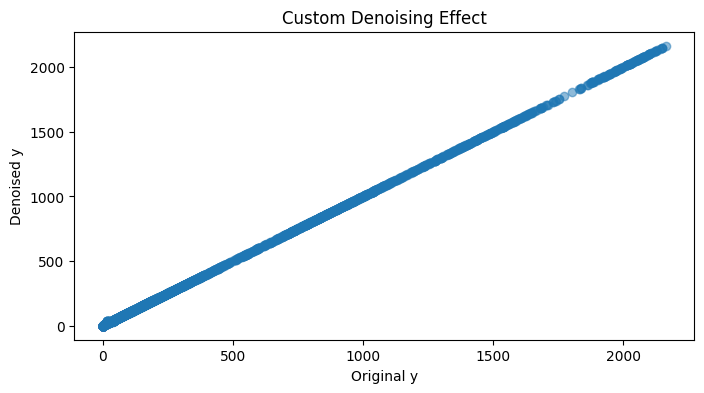

In [7]:
%matplotlib inline
y_denoised = bound_denoise(X, y, length_scale_bounds=(1e-3, 20), noise_level_bounds=(1e-5, 100), show_denoising_effect=True)

In [8]:
data_denoised = data.copy()
data_denoised['Customer Value'] = y_denoised
data_denoised.to_csv('data/customer_churn_denoised.csv', index=False)

In [9]:
sr_model = PySRRegressor(
        niterations=1024,  # Number of iterations to search for equations
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["log", "abs", "sqrt"],
        maxdepth=10,
        elementwise_loss="loss(x, y) = (x - y)^2",  # Define loss function (mean squared error)
        verbosity=0,
        maxsize=50
    )
sr_model.fit(X, y_denoised)

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          470.93906   
	1         7.775634e-01                                      x1 * 4.908899   
	2         1.005308e-01                               sqrt(x1) * 77.359505   
	3         9.669737e-01                              (x2 + x1) * 3.5374887   
	4         1.097691e-01                       (sqrt(x3) + x1) / 0.26181018   
	5         4.665016e-01               (x3 * 0.039100844) + (x1 * 4.091296)   
	6         1.238998e-03  ((x1 * 4.107606) - (x3 * -0.03990492)) - 8.131272   
	7         1.962735e-03  (x3 * 0.03954782) + abs((x1 * 4.1184406) + -8....   
	8         6.515736e-02  (x1 - (-0.008124629 * x3)) * (3.8808806 - (x2 ...   
	9         2.912138e-03  (((x3 * -0.007726749) - x1) * ((x2 * -0.004680...   
	10  >>>>  1.155367e-01  (((x3 * 0.0026057335) * log(abs(x2 + (-103.499...   
	11        4.565163e-03  (x1 * 3.846672) + (x3 * (abs(log(abs(x2 + (-10...   
	12        4.000659e-02  ((x3 * (log(abs(((x0 + -141.4553) - x1) + x2))...   
	13        3.556492e-03  (x1 * 3.8711646) + abs((log(abs((x0 + -140.459...   
	14        1.341328e-03  ((x3 + x2) * abs(log(abs(((x2 + x0) - x1) + -1...   
	15        1.956829e-02  ((log(abs((x2 + -104.454384) - x1)) * ((x3 - (...   
	16        4.811233e-03  abs((log(abs(x2 + (-102.7606 - x1))) * ((x3 - ...   
	17        2.817134e-02  ((x3 - (x2 * -35.31316)) * (log(abs(x2 + ((x0 ...   
	18        3.743346e-03  ((x1 * 3.845514) + ((((x2 * -33.852993) - x3) ...   
	19        5.040572e-04  ((log(abs(x0 + ((x2 + -144.45491) - x1))) * ((...   
	20        2.493357e-03  ((x0 * -1.3929499) + (3.8410585 * x1)) + abs(l...   
	21        7.171708e-04  (3.8410585 * x1) + abs((x0 * -1.3929499) + abs...   
	22        5.395272e-05  abs((-1.3929499 * x0) + abs(log(abs((x2 - x1) ...   
	23        4.177212e-07  (3.8410585 * x1) + abs((x0 * -1.3929499) + abs...   
	24        4.817836e-05  (3.8410585 * x1) + abs((-1.3929499 * x0) + abs...   
	25        4.654779e-03  (((x2 * (log(abs(x1 - (x2 + -36.53604))) * -0....   
	26        3.271306e-03  (((x1 * 3.888121) + (x3 * 0.023316033)) - ((x2...   
	27        6.219635e-03  ((x3 * 0.024878401) + ((x1 * 3.9164777) - (x2 ...   
	28        3.781059e-02  (sqrt(sqrt(x2) * abs((x2 + (-94.73635 - x1)) *...   
	29        2.946748e-03  (sqrt(abs((sqrt(x2) * ((-95.77774 - x1) + x2))...   
	30        9.346439e-03  sqrt(abs(((-95.87258 - x1) + x2) * (sqrt(x2) *...   
	31        1.164519e-02  (x1 * 3.6765034) + ((sqrt(abs((sqrt(x2) * ((-9...   
	32        1.940215e-04  (x3 * 0.031579465) + (abs(sqrt(abs(((x2 + -93....   
	33        1.301819e-02  ((((x3 * 0.033524737) + ((x1 * 3.582894) - 30....   
	34        8.218694e-03  ((((x1 * 3.6159098) - (sqrt(x3) + x0)) + sqrt(...   
	35        9.698912e-03  ((x3 * 0.03582971) + (((x1 * 3.4568202) - 70.0...   
	36        1.540742e-04  abs((sqrt(sqrt(x2 + 0.4864858) * abs((x1 - (x2...   
	37        1.903299e-02  ((x3 * 0.03561761) - sqrt((x2 * 4.313995) * ab...   
	38        9.639151e-04  ((x3 * 0.035316836) - sqrt(abs(((x2 + x0) + ((...   
	39        9.261720e-03  ((x3 * 0.036917333) - sqrt(abs((x2 * 3.9015505...   
	40        2.670989e-04  abs(((x3 * 0.0369343) - sqrt((x2 * 3.9009178) ...   
	41        1.429873e-02  (sqrt(abs((((x2 + 67.51247) * 1.5668223) - (x0...   
	42        5.967005e-04  abs((sqrt(abs((((x2 + 67.51247) * 1.5668223) -...   
	
	           loss  complexity  
	0   267168.4000           1  
	1    56415.9800           3  
	2    51020.2000           4  
	3    19399.5120           5  
	4    17382.7580           6  
	5    10902.3370           7  
	6    10875.3545           9  
	7    10854.0300          10  
	8    10169.3580          11  
	9    10110.3010          13  
	10    8024.3560          15  
	11    7987.8070          16  
	12    7674.5500          17  
	13    7647.3040          18  
	14    7626.8164          20  
	15    7479.0234          21  
	16    744

In [5]:
# 20250501_143744_9PpWRF
# Complexity 17
candidate_function = generate_candidate_function("((x3 * (log(abs(((x0 + -141.4553) - x1) + x2)) * 0.0025179593)) + x1) * 3.8717575")
# candidate_function = generate_candidate_function("0.5136726*x2 + 1.2973638799338*sqrt(x4) + 0.5136726*sqrt(Abs(x1)) + 0.5136726*Abs(x3 + log(x5)*sin(2.48172932259734*sin(log(x5) - 0.88440996)))")

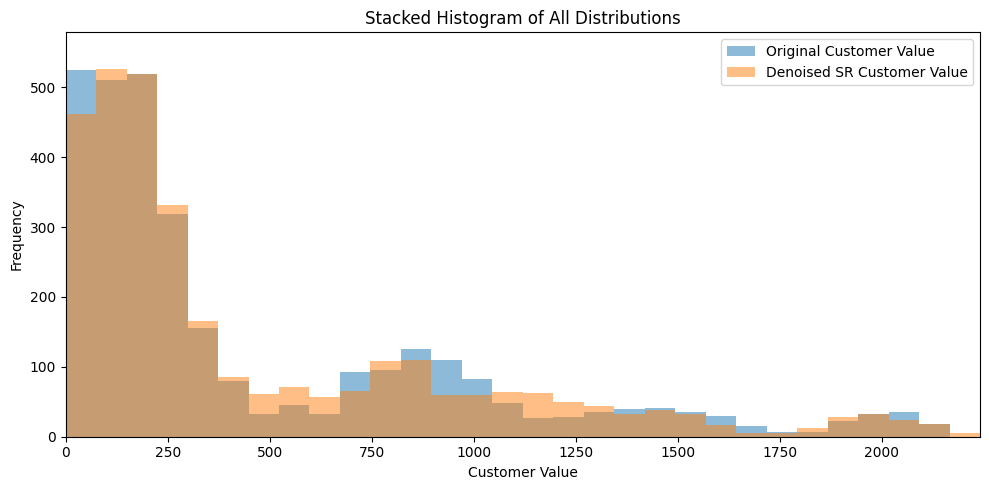

In [6]:
# X_aux = X[:, [0, 2]]
# y_denoised_sr = candidate_function(X_aux)
y_denoised_sr = candidate_function(X)
plot_histograms([(y, 'Original Customer Value', None), (y_denoised_sr, 'Denoised SR Customer Value', None)], 'Customer Value', stack=True, figsize_per_plot=(10, 5))

In [14]:
kscomplement_score = KSComplement.compute(
    real_data=y,
    synthetic_data=y_denoised_sr
)
print(f'KSComplement Score = {round(kscomplement_score * 100, 2)}%')

KSComplement Score = 97.17%


<Figure size 640x480 with 0 Axes>

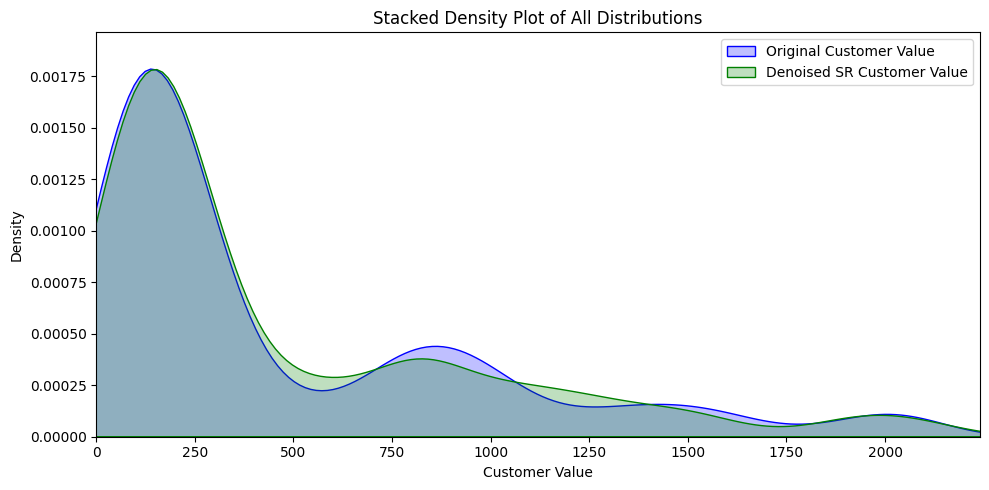

In [7]:
plot_densities([(y, 'Original Customer Value', 'blue'), (y_denoised_sr, 'Denoised SR Customer Value', 'green')], 'Customer Value', stack=True, figsize_per_plot=(10, 5))

In [9]:
orig_residuals = y - y_denoised_sr

In [10]:
y_corrected, best_amp, errors, _ = correct_predictions(y, y_denoised_sr, method='stratified', seed=42, clip_lower=0, clip_upper=None, original_residuals=None, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run

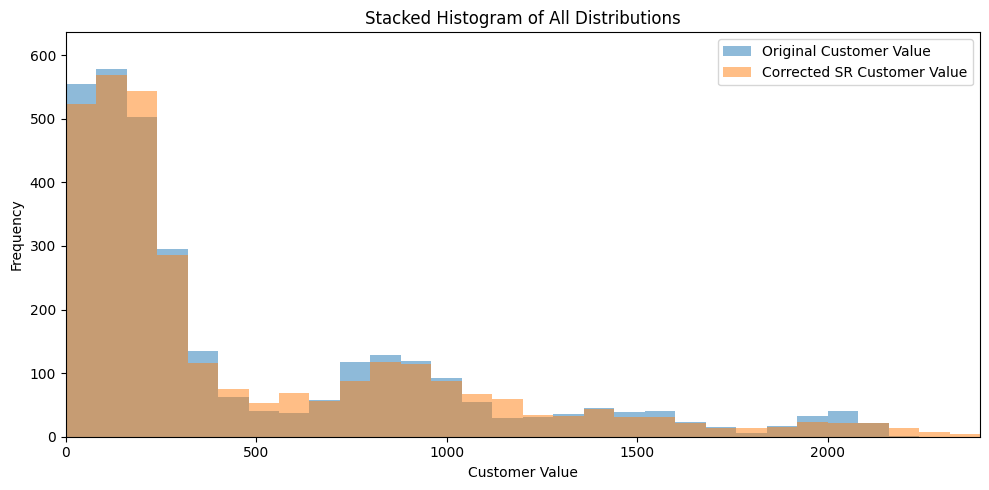

In [11]:
plot_histograms([(y, 'Original Customer Value', None), (y_corrected, 'Corrected SR Customer Value', None)], 'Customer Value', stack=True, figsize_per_plot=(10, 5))

In [15]:
kscomplement_score = KSComplement.compute(
    real_data=y,
    synthetic_data=y_corrected
)
print(f'KSComplement Score = {round(kscomplement_score * 100, 2)}%')

KSComplement Score = 97.49%


<Figure size 640x480 with 0 Axes>

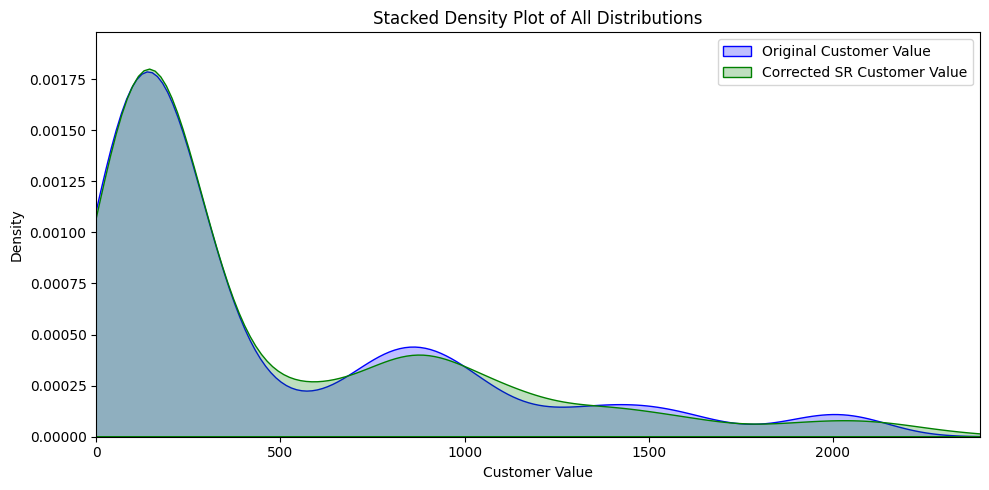

In [12]:
plot_densities([(y, 'Original Customer Value', 'blue'), (y_corrected, 'Corrected SR Customer Value', 'green')], 'Customer Value', stack=True, figsize_per_plot=(10, 5))

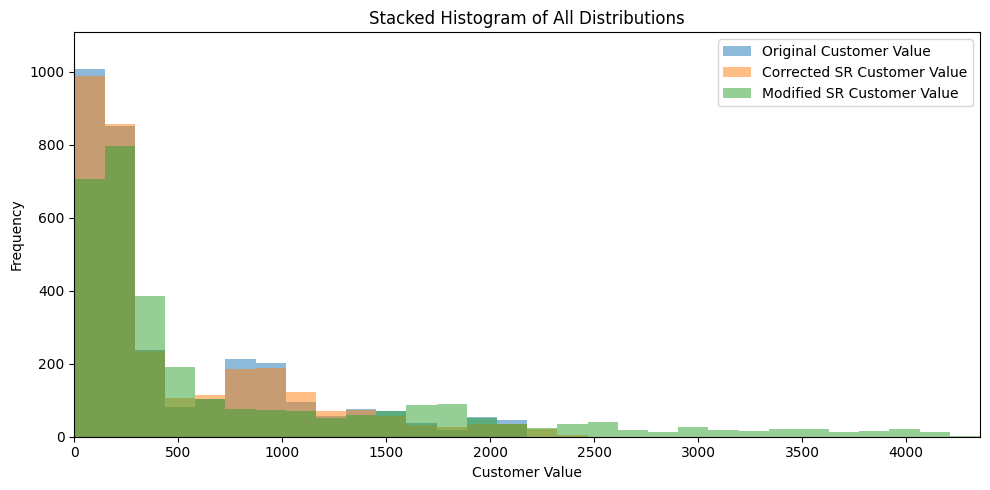

In [13]:
mod_candidate_function = generate_candidate_function("((x3 * (log(abs(((x0 + -141.4553) - x1) + x2)) * 0.0025179593)) + 2*x1) * 3.8717575")
mod_y_sr = mod_candidate_function(X)
mod_y_corrected, best_amp, errors, _ = correct_predictions(y, mod_y_sr, method='stratified', amplification_factor=1.0, seed=42, clip_lower=0, clip_upper=None, original_residuals=orig_residuals, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run
plot_histograms([(y, 'Original Customer Value', None), (y_corrected, 'Corrected SR Customer Value', None), (mod_y_corrected, 'Modified SR Customer Value', None)], 'Customer Value', stack=True, figsize_per_plot=(10, 5))